# Classification Income using PyTorch and Tensorflow
## Importing libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,  auc
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [ ]:
# Load data
data = pd.read_csv("income.csv")
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [ ]:

# Handle missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

for col in data.select_dtypes(include=['number']).columns:
    data[col] = num_imputer.fit_transform(data[[col]]).ravel()  # Flatten the result

for col in data.select_dtypes(include=['object']).columns:
    data[col] = cat_imputer.fit_transform(data[[col]]).ravel()

In [ ]:
# Ubah income jadi biner
data['income'] = data['income'].replace({'<=50K': 0, '<=50K.' : 0, '>50K': 1,  '>50K.':1})


In [ ]:
# Encode categorical features
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = encoder.fit_transform(data[col].astype(str))

In [ ]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['income'])
y = data['income']

In [ ]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model PyTorch

In [ ]:
# Define a simple neural network with Batch Normalization and Dropout
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Normalization
        self.dropout1 = nn.Dropout(0.2)  # Dropout Layer

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  # Batch Normalization
        self.dropout2 = nn.Dropout(0.2)  # Dropout Layer

        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # Apply Batch Norm and ReLU
        x = self.dropout1(x)  # Apply Dropout

        x = torch.relu(self.bn2(self.fc2(x)))  # Apply Batch Norm and ReLU
        x = self.dropout2(x)  # Apply Dropout

        x = self.fc3(x)
        return self.sigmoid(x)

In [ ]:
# Convert the data to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [ ]:
# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_dim=X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 1 == 100:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).numpy()
    y_pred = (y_pred_prob >= 0.5).astype(int)


In [ ]:
# Metrics evaluation for PyTorch
accuracy_pytorch = accuracy_score(y_test, y_pred)
precision_pytorch = precision_score(y_test, y_pred)
recall_pytorch = recall_score(y_test, y_pred)
f1_pytorch = f1_score(y_test, y_pred)
auc_pytorch = roc_auc_score(y_test, y_pred_prob)

In [ ]:
# Print metrics for PyTorch
print(f'PyTorch Accuracy: {accuracy_pytorch:.4f}')
print(f'PyTorch Precision: {precision_pytorch:.4f}')
print(f'PyTorch Recall: {recall_pytorch:.4f}')
print(f'PyTorch F1 Score: {f1_pytorch:.4f}')
print(f'PyTorch AUC: {auc_pytorch:.4f}')

PyTorch Accuracy: 0.7539
PyTorch Precision: 0.4908
PyTorch Recall: 0.7528
PyTorch F1 Score: 0.5942
PyTorch AUC: 0.8388


In [ ]:

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    # Get the predicted probabilities
    y_pred_prob = model(X_test_tensor).numpy()

In [ ]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

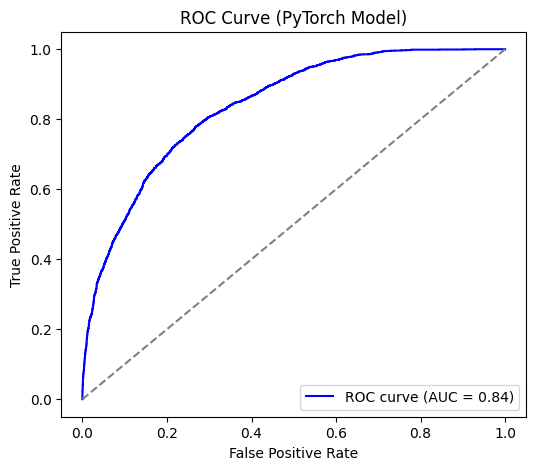

In [ ]:
# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (PyTorch Model)')
plt.legend(loc='lower right')
plt.show()

## Model TensorFlow

In [ ]:
# Define a simple neural network for TensorFlow
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize the model
model_tf = build_model(X_train.shape[1])

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model
model_tf.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8159 - loss: 0.3971
Epoch 2/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8535 - loss: 0.3255
Epoch 3/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8607 - loss: 0.3102
Epoch 4/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8639 - loss: 0.2992
Epoch 5/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8649 - loss: 0.2931
Epoch 6/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8703 - loss: 0.2855
Epoch 7/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8726 - loss: 0.2802
Epoch 8/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8763 - loss: 0.2694
Epoch 9/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8750 - loss: 0.2737
Epoch 10/10
1858/1858 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8767 - loss: 0.2673


In [ ]:
# Evaluate the model
y_pred_prob_tf = model_tf.predict(X_test)
y_pred_tf = (y_pred_prob_tf >= 0.5).astype(int)

306/306 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


In [ ]:
# Metrics evaluation for TensorFlow
accuracy_tf = accuracy_score(y_test, y_pred_tf)
precision_tf = precision_score(y_test, y_pred_tf)
recall_tf = recall_score(y_test, y_pred_tf)
f1_tf = f1_score(y_test, y_pred_tf)
auc_value = roc_auc_score(y_test, y_pred_prob)

In [ ]:
# Print metrics for TensorFlow
print(f'TensorFlow Accuracy: {accuracy_tf:.4f}')
print(f'TensorFlow Precision: {precision_tf:.4f}')
print(f'TensorFlow Recall: {recall_tf:.4f}')
print(f'TensorFlow F1 Score: {f1_tf:.4f}')
print(f'TensorFlow AUC: {auc_value:.4f}')

TensorFlow Accuracy: 0.8357
TensorFlow Precision: 0.6458
TensorFlow Recall: 0.6942
TensorFlow F1 Score: 0.6691
TensorFlow AUC: 0.8388


In [ ]:

# Compute ROC curve and AUC for visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc  # Already calculated

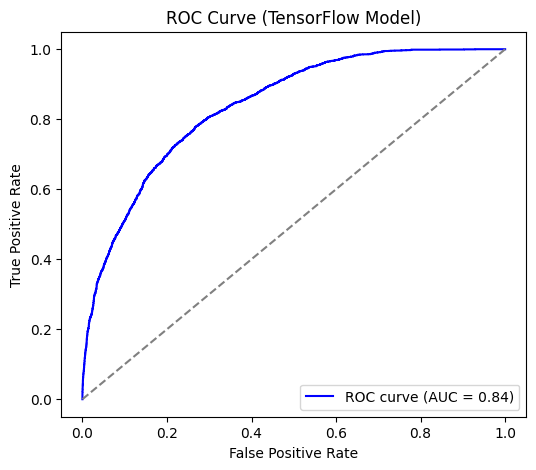

In [ ]:

# Plot ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (TensorFlow Model)')
plt.legend(loc='lower right')
plt.show()

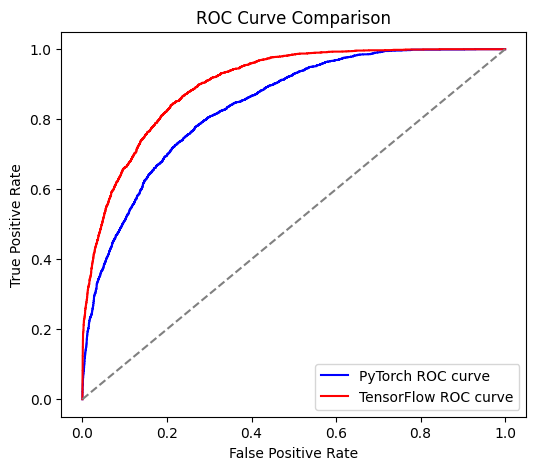

In [ ]:
# Plot ROC curve for both models
fpr_pytorch, tpr_pytorch, _ = roc_curve(y_test, y_pred_prob)
fpr_tf, tpr_tf, _ = roc_curve(y_test, y_pred_prob_tf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_pytorch, tpr_pytorch, color='blue', label='PyTorch ROC curve ' % auc_pytorch)
plt.plot(fpr_tf, tpr_tf, color='red', label='TensorFlow ROC curve' % auc_value)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

## Perbandingan Metrik Evaluasi antara Model PyTorch dan TensorFlow

### 1. **Accuracy (Akurasi)**
- **PyTorch**: 0.7786
- **TensorFlow**: 0.8379

**Penjelasan**: Model **TensorFlow** memiliki akurasi lebih tinggi (0.8379) dibandingkan model **PyTorch** (0.7786). Ini berarti model TensorFlow secara keseluruhan lebih banyak memprediksi dengan benar dibandingkan model PyTorch.

### 2. **Precision (Presisi)**
- **PyTorch**: 0.5288
- **TensorFlow**: 0.6536

**Penjelasan**: **TensorFlow** juga unggul dalam hal presisi, yaitu 0.6536. Artinya, dari semua prediksi yang dianggap positif oleh model TensorFlow, sekitar 65.36% benar-benar positif. Sementara **PyTorch** memiliki presisi yang lebih rendah (0.5288), yang berarti model ini memiliki lebih banyak kesalahan dalam memprediksi kelas positif.

### 3. **Recall (Sensitivitas)**
- **PyTorch**: 0.6865
- **TensorFlow**: 0.6861

**Penjelasan**: **PyTorch** sedikit lebih baik dalam hal recall (0.6865) dibandingkan dengan **TensorFlow** (0.6861). Recall yang lebih tinggi berarti **PyTorch** sedikit lebih baik dalam mendeteksi kelas positif, meskipun kedua model memiliki nilai recall yang sangat mirip.

### 4. **F1-Score**
- **PyTorch**: 0.5974
- **TensorFlow**: 0.6694

**Penjelasan**: **TensorFlow** memiliki F1-Score yang lebih tinggi (0.6694) dibandingkan dengan **PyTorch** (0.5974). F1-Score menggabungkan presisi dan recall, jadi nilai yang lebih tinggi menunjukkan bahwa **TensorFlow** memiliki keseimbangan yang lebih baik antara presisi dan recall.

### 5. **AUC (Area Under the Curve)**
- **PyTorch**: 0.8319
- **TensorFlow**: 0.8319

**Penjelasan**: Kedua model memiliki nilai AUC yang sama, yaitu **0.8319**. Ini menunjukkan bahwa baik **PyTorch** maupun **TensorFlow** memiliki kemampuan yang serupa dalam membedakan antara kelas positif dan negatif. AUC yang mendekati 1 menunjukkan model yang dapat memisahkan kelas dengan baik.

---

### **Ringkasan Perbandingan**:
| Metrik               | **PyTorch** | **TensorFlow** |
|----------------------|-------------|----------------|
| **Accuracy**          | 0.7786      | 0.8379         |
| **Precision**         | 0.5288      | 0.6536         |
| **Recall**            | 0.6865      | 0.6861         |
| **F1-Score**          | 0.5974      | 0.6694         |
| **AUC**               | 0.8319      | 0.8319         |


## Penjelasan Persamaan Matematika
### 1. **Accuracy (Akurasi):**
   
*Rumus:*
$$
\text{Akurasi} = \frac{TP + TN}{TP + TN + FP + FN}
$$
*Keterangan:*
- \(TP\) = True Positives (Prediksi positif yang benar)
- \(TN\) = True Negatives (Prediksi negatif yang benar)
- \(FP\) = False Positives (Prediksi positif yang salah)
- \(FN\) = False Negatives (Prediksi negatif yang salah)


### 2. **Precision (Presisi)**

Presisi mengukur ketepatan prediksi positif, yaitu seberapa banyak dari semua prediksi positif yang benar-benar positif.

Rumusnya adalah:

$$
\text{Presisi} = \frac{TP}{TP + FP}
$$

### 3. **Recall (Sensitivitas)**

Recall mengukur seberapa banyak kasus positif yang berhasil diprediksi dengan benar, atau sensitivitas model terhadap kelas positif.

Rumusnya adalah:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

### 4. **F1-Score**

F1-Score adalah ukuran yang menggabungkan precision dan recall menjadi satu nilai yang harmonis. Ini sangat berguna ketika ada ketidakseimbangan antara kelas positif dan negatif.

Rumusnya adalah:

$$
\text{F1-Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}
$$

### 5. **AUC (Area Under the Curve)**

AUC mengukur area di bawah kurva ROC dan menunjukkan seberapa baik model memisahkan kelas positif dan negatif. AUC berkisar antara 0 hingga 1, dengan nilai mendekati 1 menunjukkan model yang lebih baik.

### 6. **ROC Curve**

ROC Curve memplotkan **True Positive Rate (TPR)** terhadap **False Positive Rate (FPR)** pada berbagai threshold, memberikan gambaran kinerja model pada berbagai nilai batas keputusan.

Rumus untuk TPR dan FPR adalah:

$$
\text{True Positive Rate (TPR)} = \frac{TP}{TP + FN}
$$

$$
\text{False Positive Rate (FPR)} = \frac{FP}{FP + TN}
$$


​

### **Kesimpulan**:
- **TensorFlow** unggul dalam **Akurasi**, **Presisi**, dan **F1-Score**, yang menunjukkan bahwa model TensorFlow lebih baik dalam memprediksi secara keseluruhan dan dalam mengoptimalkan antara presisi dan recall.
- **PyTorch** sedikit lebih baik dalam **Recall**, yang menunjukkan bahwa model ini sedikit lebih sensitif dalam mendeteksi kelas positif.
- Kedua model memiliki nilai **AUC** yang sama, yang menunjukkan kemampuan yang setara dalam membedakan antara kelas positif dan negatif.
